In [38]:
import numpy as np
%load_ext autoreload
%autoreload 2

from core.gradient_descent import *
from core.visualizer import *
from core.optimizer_evaluator import *
from core.utils import fn_sum
from core.analzyer import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Иллюстрация работы модификаций GD в двумерном случае

Best value found: x* = [ 0.0005748  -0.01914443] with f(x*) = 0.0029455968512670096
Best value found: x* = [0.00190022 0.01826429] with f(x*) = 0.002350908540349304
Best value found: x* = [-0.01569434 -0.02998255] with f(x*) = 0.0063125490552829126
Best value found: x* = [ 0.01310948 -0.01611714] with f(x*) = 0.006058654151386374
Best value found: x* = [-0.00508985  0.00508985] with f(x*) = 0.000760604201909986


Text(0.5, 0.98, 'Adam')

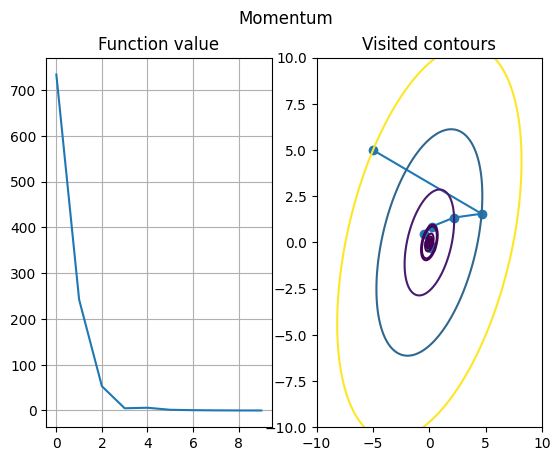

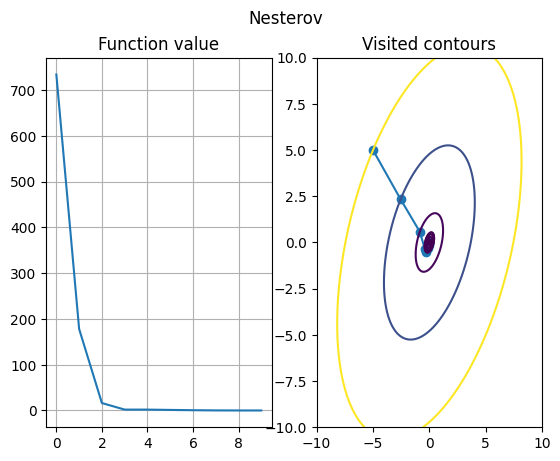

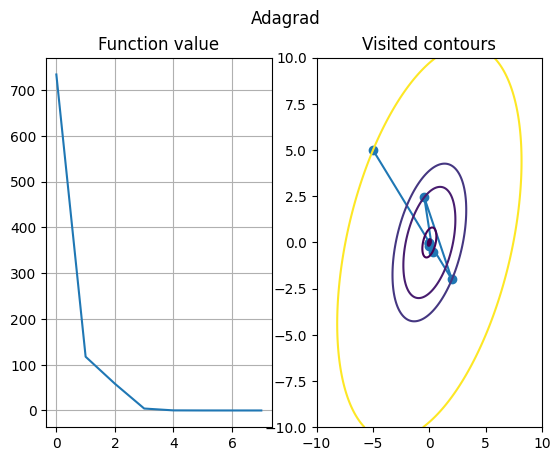

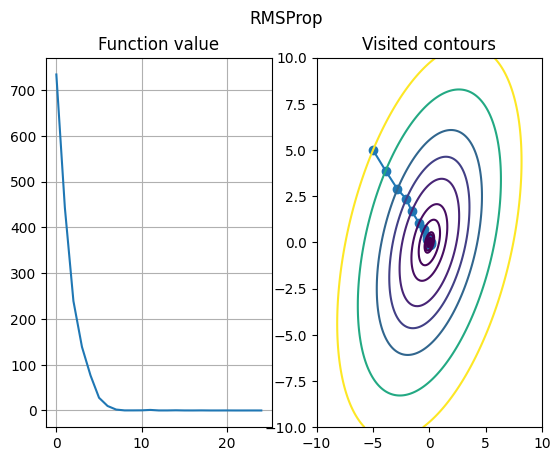

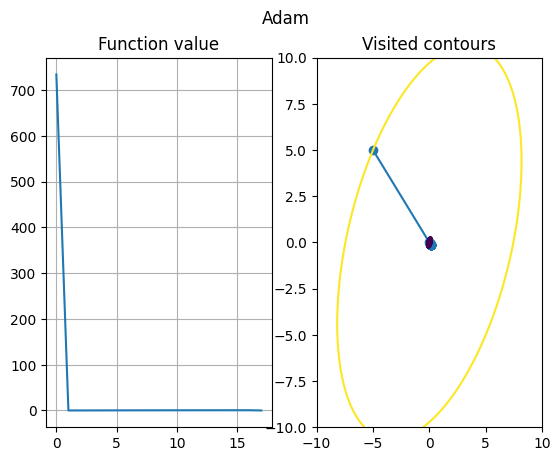

In [39]:
roi=SearchRegion2d((-10, 10), (-10, 10))
x0 = np.array([-5, 5])

f1 = generate_positive_definite_quadratic_form(2, 4, random_orthonormal_basis)
f2 = generate_positive_definite_quadratic_form(2, 6, random_orthonormal_basis)
f3 = generate_positive_definite_quadratic_form(2, 8, random_orthonormal_basis)

fs = [f1, f2, f3]
dfs = [f1.gradient_function(), f2.gradient_function(), f3.gradient_function()]

f = fn_sum(*fs)
df = fn_sum(*dfs)

def terminate(ff, steps):
    return ff(steps[-1]) < 0.01 or len(steps) > 1000

batch = 2
momentum_scheduler = step_learning_scheduler(0.1, 1, 1, batch, len(fs))

momentum = gradient_descent_minibatch_with_momentum(0.3)(
    fs, dfs, batch, x0,
    momentum_scheduler,
    terminate
)

visualize_optimizing_process(f, roi, np.array(momentum)).suptitle('Momentum')

nesterov = gradient_descent_minibatch_with_momentum(0.7, True)(
    fs, dfs, batch, x0,
    momentum_scheduler,
    terminate
)

visualize_optimizing_process(f, roi, np.array(nesterov)).suptitle('Nesterov')

adagrad = gradient_descent_minibatch_adagrad(fs, dfs, batch, x0, exponential_learning_scheduler(7, 0.1, batch, len(fs)), terminate)
visualize_optimizing_process(f, roi, np.array(adagrad)).suptitle('Adagrad')

rmsprop = gradient_descent_minibatch_rms_prop(0.2)(
    fs, dfs, batch, x0,
    exponential_learning_scheduler(1, 0.2, batch, len(fs)),
    terminate
)

visualize_optimizing_process(f, roi, np.array(rmsprop)).suptitle('RMSProp')

adam = steepest_descent_adam(0.9, 0.999)(f, df, x0, bin_search_with_iters(5), terminate)
visualize_optimizing_process(f, roi, np.array(adam)).suptitle('Adam')


### Требуемость к ресурсам

Рассмотрим потанциальные критерии для сравнения производительности:
1. Потребление памяти
2. Время исполнения
3. Количество арифмитических операций

Заметим, что все реализации алгоритмов потребляют памяти прямопропорционально размеру батча, остальные расходы памяти слишком малы, чтобы их учитывать. Поэтому этот критерий не подходит для сравнения.

Время исполнения также является не очень подходящим критерием для сравнения алгоритмов, так как он сильно зависит от железа, компилятора/интерпритатора языка реализации и его возможности оптицмизации. Даже при получении некоторых измерений довольно сложно сделать хоть сколько-нибудь общие выводы о производительности.

При сравнении количество арифмитических операций стоит учитывать, что основной вклад будет производиться от вычисления самой функции или ее производной. Поэтому для получения сравнительной характеристики методов будет использоваться подсчет количества вычислений функции или ее производной, а не всех арифмитических операций.

В таблице в каждой строчке указаны результаты запуска всех алгоритмов на одной функции. Данные даны в формате <вычислитеьные затраты>/<количество итераций>.


In [40]:
from tabulate import tabulate

def test(functions_count, condition_number):
    for batch in range(1, functions_count + 1):
        data = {}

        for i in range(5):
            fs = [generate_positive_definite_quadratic_form(5, condition_number, random_orthonormal_basis) for _ in range(functions_count)]
            dfs = [f.gradient_function() for f in fs]
            test = test_perfomance(fs, dfs, batch, np.array([-5, -5, 2, -3, 1]))
            for label, result in test:
                if label not in data:
                    data[label] = []
                data[label].append(result)

        print(f"With batch = {batch}")
        print(tabulate(data, headers="keys", tablefmt="grid"))
        print()

In [41]:
test(4, 3)

With batch = 1
+-------------+------------+------------+-----------+-----------+---------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam    |
+=============+============+============+===========+===========+=========+
| 44/9        | 44/9       | 69/14      | 39/8      | 329/66    | 5188/86 |
+-------------+------------+------------+-----------+-----------+---------+
| 39/8        | 44/9       | 69/14      | 44/9      | 329/66    | 5160/85 |
+-------------+------------+------------+-----------+-----------+---------+
| 34/7        | 44/9       | 79/16      | 64/13     | 329/66    | 4840/80 |
+-------------+------------+------------+-----------+-----------+---------+
| 39/8        | 44/9       | 74/15      | 39/8      | 334/67    | 5020/83 |
+-------------+------------+------------+-----------+-----------+---------+
| 39/8        | 44/9       | 69/14      | 54/11     | 309/62    | 5016/83 |
+-------------+------------+------------+-----------+-----------+--------

In [42]:
test(4, 10)

With batch = 1
+-------------+------------+------------+-----------+-----------+---------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam    |
+=============+============+============+===========+===========+=========+
| 5004/1001   | 209/42     | 139/28     | 89/18     | 409/82    | 5408/90 |
+-------------+------------+------------+-----------+-----------+---------+
| 5004/1001   | 264/53     | 334/67     | 74/15     | 389/78    | 5424/90 |
+-------------+------------+------------+-----------+-----------+---------+
| 5004/1001   | 189/38     | 129/26     | 99/20     | 384/77    | 5448/91 |
+-------------+------------+------------+-----------+-----------+---------+
| 5004/1001   | 179/36     | 134/27     | 84/17     | 389/78    | 4936/83 |
+-------------+------------+------------+-----------+-----------+---------+
| 5004/1001   | 5004/1001  | 149/30     | 94/19     | 404/81    | 5184/87 |
+-------------+------------+------------+-----------+-----------+--------

In [43]:
test(4, 20)

With batch = 1
+-------------+------------+------------+-----------+-----------+----------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam     |
+=============+============+============+===========+===========+==========+
| 155/31      | 5004/1001  | 5004/1001  | 114/23    | 444/89    | 5692/96  |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 5004/1001  | 5004/1001  | 109/22    | 429/86    | 5784/96  |
+-------------+------------+------------+-----------+-----------+----------+
| 145/29      | 5004/1001  | 5004/1001  | 99/20     | 449/90    | 6040/101 |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 5004/1001  | 5004/1001  | 169/34    | 429/86    | 5636/95  |
+-------------+------------+------------+-----------+-----------+----------+
| 165/33      | 5004/1001  | 5004/1001  | 134/27    | 409/82    | 5736/97  |
+-------------+------------+------------+-----------+--------

## Анализ результатов

### Ресурсы
При сходимости методы Momentum и Nesterov потребляют меньше ресурсов, если оценивать количество вызовов подсчета фукнции и ее производой. Больше всего ресурсов потребляет алгоритм Adam, несмотря на то, что по двумерному случаю видно, что алгоритм быстро приходит к миниуму, но достижение заданной точности занимает больую часть шагов.

### Сходимость
Результаты сходимости прямопропорциональны результатам затрат ресурсов: чем меньше вычислялась функция, тем меньше итераций алгоритма требовалось. При "простых" функциях все алгоритмы почти всегда сходятся.

### Надежность
При увеличении числа обусловленности, что усложняет поиск минимума функции, методы Momentum и Nesterov, построенные на схожей идеи, перестают сходиться. Начальные моменты становяться слишком большими, что вличет к расходимости. При этом, если поставить достаточно малый момент, то сам алгоритм потеряет смысл, так как не будет ничем отличаться от SGD. При этом алгоритмы AdaGrad, RMSProp и Adam показывают стабильную сходимость. При этом корректировка коэффициентов не требуется.